In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.4 MB/s eta 0:00:00


In [13]:
import torch
import torch.nn.functional as F
from torch.nn import Linear

from torch_geometric.datasets import UPFD
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, GCNConv, SAGEConv, global_max_pool, global_mean_pool
from torch_geometric.transforms import ToUndirected

from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.manifold import TSNE

In [4]:
from google.colab import drive
drive.mount('/content/drive')
path = 'drive/MyDrive/CS365/data/UPFD'

Mounted at /content/drive


In [5]:
pf_train = UPFD(path, 'politifact', 'bert', 'train', ToUndirected())
pf_val = UPFD(path, 'politifact', 'bert', 'val', ToUndirected())
pf_test = UPFD(path, 'politifact', 'bert', 'test', ToUndirected())
pf_all = pf_train + pf_val + pf_test

gc_train = UPFD(path, 'gossipcop', 'bert', 'train', ToUndirected())
gc_val = UPFD(path, 'gossipcop', 'bert', 'val', ToUndirected())
gc_test = UPFD(path, 'gossipcop', 'bert', 'test', ToUndirected())
gc_all = gc_train + gc_val + gc_test

In [6]:
print("==== POLITIFACT ====")
print("Train:", pf_train)
print("Val:", pf_val)
print("Test:", pf_test)
print("All:", pf_all)

print("\n==== GOSSIPCOP ====")
print("Train:", gc_train)
print("Val:", gc_val)
print("Test:", gc_test)
print("All:", gc_all)

==== POLITIFACT ====
Train: UPFD(62, name=politifact, feature=bert)
Val: UPFD(31, name=politifact, feature=bert)
Test: UPFD(221, name=politifact, feature=bert)
All: <torch.utils.data.dataset.ConcatDataset object at 0x7b2692b88490>

==== GOSSIPCOP ====
Train: UPFD(1092, name=gossipcop, feature=bert)
Val: UPFD(546, name=gossipcop, feature=bert)
Test: UPFD(3826, name=gossipcop, feature=bert)
All: <torch.utils.data.dataset.ConcatDataset object at 0x7b2692b88a60>


In [7]:
# Aggregate train, val, and test sets
pf_sets = {"Train": pf_train, "Val": pf_val, "Test": pf_test, "All": pf_all}
gc_sets = {"Train": gc_train, "Val": gc_val, "Test": gc_test, "All": gc_all}

pf_total_news = {"Train": [0,0], "Val": [0,0], "Test": [0,0], "All": [0,0]}
gc_total_news = {"Train": [0,0], "Val": [0,0], "Test": [0,0], "All": [0,0]}

pf_total_rt = {"Train": [0,0], "Val": [0,0], "Test": [0,0], "All": [0,0]}
gc_total_rt = {"Train": [0,0], "Val": [0,0], "Test": [0,0], "All": [0,0]}

pf_total_edges = {"Train": [0,0], "Val": [0,0], "Test": [0,0], "All": [0,0]}
gc_total_edges = {"Train": [0,0], "Val": [0,0], "Test": [0,0], "All": [0,0]}

isolated_nodes = 0

for set_split in ["Train", "Val", "Test"]:
    for news_graph in pf_sets[set_split]:
        pf_total_news[set_split][int(news_graph.y)] += 1
        pf_total_rt[set_split][int(news_graph.y)] += news_graph.num_nodes
        pf_total_edges[set_split][int(news_graph.y)] += news_graph.num_edges

        isolated_nodes += news_graph.has_isolated_nodes()

    for news_graph in gc_sets[set_split]:
        gc_total_news[set_split][int(news_graph.y)] += 1
        gc_total_rt[set_split][int(news_graph.y)] += news_graph.num_nodes
        gc_total_edges[set_split][int(news_graph.y)] += news_graph.num_edges

        isolated_nodes += news_graph.has_isolated_nodes()

for set_split in ["Train", "Val", "Test"]:
    for i in range(2):
        pf_total_news["All"][i] += pf_total_news[set_split][i]
        gc_total_news["All"][i] += gc_total_news[set_split][i]

        pf_total_rt["All"][i] += pf_total_rt[set_split][i]
        gc_total_rt["All"][i] += gc_total_rt[set_split][i]

        pf_total_edges["All"][i] += pf_total_edges[set_split][i]
        gc_total_edges["All"][i] += gc_total_edges[set_split][i]


In [8]:
print("==== POLITIFACT ====")
print("COUNT:", pf_total_news)
print("NODES:", pf_total_rt)
print("EDGES:", pf_total_edges)
print("AVG RT:", {set_split: [(pf_total_rt[set_split][0] - 1) / pf_total_news[set_split][0], (pf_total_rt[set_split][1] - 1) / pf_total_news[set_split][1]] for set_split in ["Train", "Val", "Test", "All"]})
print("AVG ND:", {set_split: [(pf_total_edges[set_split][0]//2) / pf_total_rt[set_split][0], (pf_total_edges[set_split][1]//2) / pf_total_rt[set_split][1]] for set_split in ["Train", "Val", "Test", "All"]})

print("\n==== GOSSIPCOP ====")
print("COUNT:", gc_total_news)
print("NODES:", gc_total_rt)
print("EDGES:", gc_total_edges)
print("AVG RT:", {set_split: [(gc_total_rt[set_split][0] - 1) / gc_total_news[set_split][0], (gc_total_rt[set_split][1] - 1) / gc_total_news[set_split][1]] for set_split in ["Train", "Val", "Test", "All"]})
print("AVG ND:", {set_split: [(gc_total_edges[set_split][0]//2) / gc_total_rt[set_split][0], (gc_total_edges[set_split][1]//2) / gc_total_rt[set_split][1]] for set_split in ["Train", "Val", "Test", "All"]})


==== POLITIFACT ====
COUNT: {'Train': [36, 26], 'Val': [13, 18], 'Test': [108, 113], 'All': [157, 157]}
NODES: {'Train': [3690, 2382], 'Val': [1239, 2539], 'Test': [13113, 18091], 'All': [18042, 23012]}
EDGES: {'Train': [7308, 4712], 'Val': [2452, 5042], 'Test': [26010, 35956], 'All': [35770, 45710]}
AVG RT: {'Train': [102.47222222222223, 91.57692307692308], 'Val': [95.23076923076923, 141.0], 'Test': [121.4074074074074, 160.08849557522123], 'All': [114.91082802547771, 146.56687898089172]}
AVG ND: {'Train': [0.9902439024390244, 0.9890848026868178], 'Val': [0.9895076674737692, 0.9929105947223317], 'Test': [0.9917638984214139, 0.9937538002321596], 'All': [0.9912980822525219, 0.9931774726229793]}

==== GOSSIPCOP ====
COUNT: {'Train': [557, 535], 'Val': [265, 281], 'Test': [1910, 1916], 'All': [2732, 2732]}
NODES: {'Train': [43166, 20316], 'Val': [20187, 10604], 'Test': [144726, 75263], 'All': [208079, 106183]}
EDGES: {'Train': [85218, 39562], 'Val': [39844, 20646], 'Test': [285632, 146694]

In [ ]:
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [ ]:
graph_to_display = pf_train[4]
color_tensor = torch.empty(graph_to_display.num_nodes)
color_tensor[0] = 1

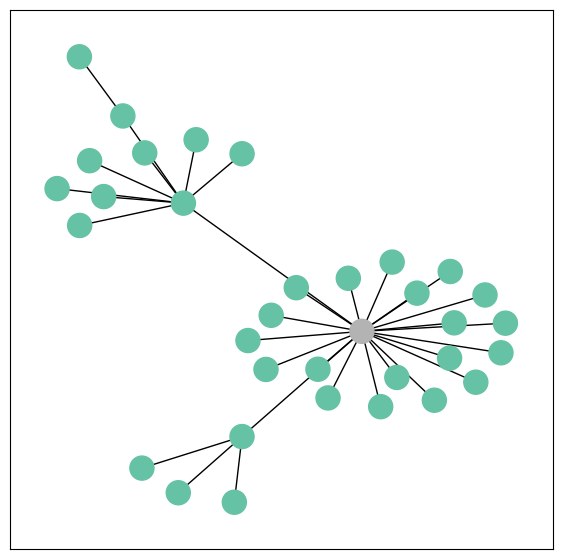

In [ ]:
from torch_geometric.utils import to_networkx

G = to_networkx(graph_to_display, to_undirected=True)
visualize_graph(G, color=color_tensor)

In [45]:
def eval_LR(train_set, test_set):
    lr_train_x = torch.stack(list(g.x[0] for g in train_set))
    lr_train_x_avg = torch.stack(list(torch.mean(g.x, 0) for g in train_set))
    lr_train_x_max = torch.stack(list(torch.max(g.x, 0)[0] for g in train_set))
    lr_train_x_cat = torch.stack(list(torch.cat((g.x[0], torch.mean(g.x[1:], 0))) for g in train_set))
    lr_train_y = torch.cat(list(g.y for g in train_set))

    print("===TRAINING===")
    print("R:", lr_train_x.shape)
    print("A:", lr_train_x_avg.shape)
    print("M:", lr_train_x_max.shape)
    print("C:", lr_train_x_cat.shape)
    print("L:", lr_train_y.shape)

    lr_test_x = torch.stack(list(g.x[0] for g in test_set))
    lr_test_x_avg = torch.stack(list(torch.mean(g.x, 0) for g in test_set))
    lr_test_x_max = torch.stack(list(torch.max(g.x, 0)[0] for g in test_set))
    lr_test_x_cat = torch.stack(list(torch.cat((g.x[0], torch.mean(g.x[1:], 0))) for g in test_set))
    lr_test_y = torch.cat(list(g.y for g in test_set))

    print("===TESTING===")
    print("R:", lr_test_x.shape)
    print("A:", lr_test_x_avg.shape)
    print("M:", lr_test_x_max.shape)
    print("C:", lr_test_x_cat.shape)
    print("L:", lr_test_y.shape)

    lr_model_regular = LogisticRegression(random_state=0, max_iter=10000).fit(lr_train_x, lr_train_y)
    lr_model_average = LogisticRegression(random_state=0, max_iter=10000).fit(lr_train_x_avg, lr_train_y)
    lr_model_maximum = LogisticRegression(random_state=0, max_iter=10000).fit(lr_train_x_max, lr_train_y)
    lr_model_concat = LogisticRegression(random_state=0, max_iter=10000).fit(lr_train_x_cat, lr_train_y)

    reg_score = lr_model_regular.score(lr_test_x, lr_test_y)
    avg_score = lr_model_average.score(lr_test_x_avg, lr_test_y)
    max_score = lr_model_maximum.score(lr_test_x_max, lr_test_y)
    cat_score = lr_model_concat.score(lr_test_x_cat, lr_test_y)

    return reg_score, avg_score, max_score, cat_score


In [46]:
eval_LR(pf_train, pf_test)

===TRAINING===
R: torch.Size([62, 768])
A: torch.Size([62, 768])
M: torch.Size([62, 768])
C: torch.Size([62, 1536])
L: torch.Size([62])
===TESTING===
R: torch.Size([221, 768])
A: torch.Size([221, 768])
M: torch.Size([221, 768])
C: torch.Size([221, 1536])
L: torch.Size([221])


(0.8009049773755657,
 0.7692307692307693,
 0.8099547511312217,
 0.8009049773755657)

In [47]:
eval_LR(pf_train+pf_val, pf_test)

===TRAINING===
R: torch.Size([93, 768])
A: torch.Size([93, 768])
M: torch.Size([93, 768])
C: torch.Size([93, 1536])
L: torch.Size([93])
===TESTING===
R: torch.Size([221, 768])
A: torch.Size([221, 768])
M: torch.Size([221, 768])
C: torch.Size([221, 1536])
L: torch.Size([221])


(0.8416289592760181,
 0.8099547511312217,
 0.8642533936651584,
 0.8416289592760181)

In [48]:
eval_LR(gc_train, gc_test)

===TRAINING===
R: torch.Size([1092, 768])
A: torch.Size([1092, 768])
M: torch.Size([1092, 768])
C: torch.Size([1092, 1536])
L: torch.Size([1092])
===TESTING===
R: torch.Size([3826, 768])
A: torch.Size([3826, 768])
M: torch.Size([3826, 768])
C: torch.Size([3826, 1536])
L: torch.Size([3826])


(0.736800836382645, 0.9417145844223732, 0.9568740198640878, 0.9025091479351803)

In [49]:
eval_LR(gc_train+gc_val, gc_test)

===TRAINING===
R: torch.Size([1638, 768])
A: torch.Size([1638, 768])
M: torch.Size([1638, 768])
C: torch.Size([1638, 1536])
L: torch.Size([1638])
===TESTING===
R: torch.Size([3826, 768])
A: torch.Size([3826, 768])
M: torch.Size([3826, 768])
C: torch.Size([3826, 1536])
L: torch.Size([3826])


(0.7341871406168322, 0.946941975953999, 0.9587036069001568, 0.9168844746471511)

In [50]:
def kmeans_acc(x, y):
    kmeans = KMeans(n_clusters=2, random_state=0, init="random", n_init=100).fit(x)
    return np.sum(kmeans.labels_ == y) / kmeans.labels_.shape[0]

In [51]:
def eval_KM(cluster_set):
    cl_set_x = torch.stack(list(g.x[0] for g in cluster_set))
    cl_set_x_avg = torch.stack(list(torch.mean(g.x, 0) for g in cluster_set))
    cl_set_x_max = torch.stack(list(torch.max(g.x, 0)[0] for g in cluster_set))
    cl_set_x_cat = torch.stack(list(torch.cat((g.x[0], torch.mean(g.x[1:], 0))) for g in cluster_set))
    cl_set_y = torch.cat(list(g.y for g in cluster_set)).numpy()

    print("===CLUSTERING===")
    print("R:", cl_set_x.shape)
    print("A:", cl_set_x_avg.shape)
    print("M:", cl_set_x_max.shape)
    print("C:", cl_set_x_cat.shape)
    print("L:", cl_set_y.shape)

    reg_score = kmeans_acc(cl_set_x, cl_set_y)
    avg_score = kmeans_acc(cl_set_x_avg, cl_set_y)
    max_score = kmeans_acc(cl_set_x_max, cl_set_y)
    cat_score = kmeans_acc(cl_set_x_cat, cl_set_y)

    return reg_score, avg_score, max_score, cat_score

In [52]:
eval_KM(pf_test)

===CLUSTERING===
R: torch.Size([221, 768])
A: torch.Size([221, 768])
M: torch.Size([221, 768])
C: torch.Size([221, 1536])
L: (221,)


(0.5203619909502263,
 0.4298642533936652,
 0.5203619909502263,
 0.4796380090497738)

In [53]:
eval_KM(pf_train+pf_val+pf_test)

===CLUSTERING===
R: torch.Size([314, 768])
A: torch.Size([314, 768])
M: torch.Size([314, 768])
C: torch.Size([314, 1536])
L: (314,)


(0.5987261146496815,
 0.43312101910828027,
 0.48089171974522293,
 0.5987261146496815)

In [54]:
eval_KM(gc_test)

===CLUSTERING===
R: torch.Size([3826, 768])
A: torch.Size([3826, 768])
M: torch.Size([3826, 768])
C: torch.Size([3826, 1536])
L: (3826,)


(0.47072660742289596,
 0.7219027705175117,
 0.7718243596445373,
 0.4683742812336644)

In [55]:
eval_KM(gc_train+gc_val+gc_test)

===CLUSTERING===
R: torch.Size([5464, 768])
A: torch.Size([5464, 768])
M: torch.Size([5464, 768])
C: torch.Size([5464, 1536])
L: (5464,)


(0.46724011713030744,
 0.42258418740849196,
 0.23151537335285505,
 0.5333089311859444)

In [40]:
class BaselineGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(BaselineGNN, self).__init__()
        torch.manual_seed(12345)

        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 64)
        self.conv3 = GCNConv(64, 32)
        self.conv4 = GCNConv(32, 16)
        self.lin = Linear(16, out_channels)

    def forward(self, x, edge_index, batch):
        h1 = self.conv1(x, edge_index).relu()
        h2 = self.conv2(h1, edge_index).relu()
        h3 = self.conv3(h2, edge_index).relu()
        h4 = self.conv4(h3, edge_index)
        h = global_max_pool(h4, batch)

        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin(h)
        return h

In [10]:
from torch_geometric.nn.conv import GraphConv

class TwoGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(TwoGNN, self).__init__()
        torch.manual_seed(12345)

        self.conv1 = GraphConv(in_channels, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        h1 = self.conv1(x, edge_index).relu()
        h2 = self.conv2(h1, edge_index)#.relu()
        h = global_max_pool(h2, batch)

        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin(h)
        return h

In [11]:
def eval_GNN(model, train_dataset, val_dataset, test_dataset, epochs=60, batch_size=9):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model=model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
    criterion = torch.nn.CrossEntropyLoss()

    def train():
        model.train()

        total_loss = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()

            total_loss += float(loss) * data.num_graphs

        return total_loss / len(train_loader.dataset)

    @torch.no_grad()
    def test(loader):
        model.eval()

        num_correct = 0
        total = 0
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=1)
            num_correct += int((pred == data.y).sum())
            total += data.num_graphs

        return num_correct / total

    train_errors = np.zeros((epochs))
    val_errors = np.zeros((epochs))

    for epoch in range(epochs):
        loss = train()
        train_acc = test(train_loader)
        val_acc = test(val_loader)
        test_acc = test(test_loader)
        train_errors[epoch] = 1 - train_acc
        val_errors[epoch] = 1 - val_acc
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
              f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

    fig, ax = plt.subplots()
    ax.plot(train_errors,'r-',label='train')
    ax.plot(val_errors,'b-',label='validation')
    ax.set_ylim(0,1); ax.set_xlim(0,epochs)
    ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
    ax.set_title('Validation Result %3.2f'%(val_errors[-1]))
    ax.legend()
    plt.show()

Epoch: 00, Loss: 0.7038, Train: 0.5110, Val: 0.4890, Test: 0.5000
Epoch: 01, Loss: 0.6162, Train: 0.8233, Val: 0.8315, Test: 0.8194
Epoch: 02, Loss: 0.5752, Train: 0.7189, Val: 0.7418, Test: 0.7256
Epoch: 03, Loss: 0.5508, Train: 0.8004, Val: 0.8168, Test: 0.8029
Epoch: 04, Loss: 0.4966, Train: 0.8773, Val: 0.8956, Test: 0.8764
Epoch: 05, Loss: 0.4594, Train: 0.8837, Val: 0.9029, Test: 0.8868
Epoch: 06, Loss: 0.4193, Train: 0.8984, Val: 0.9158, Test: 0.8970
Epoch: 07, Loss: 0.3899, Train: 0.8938, Val: 0.9121, Test: 0.9007
Epoch: 08, Loss: 0.3697, Train: 0.9057, Val: 0.9176, Test: 0.9004
Epoch: 09, Loss: 0.3550, Train: 0.9084, Val: 0.9212, Test: 0.9083
Epoch: 10, Loss: 0.3475, Train: 0.9112, Val: 0.9176, Test: 0.9075
Epoch: 11, Loss: 0.3245, Train: 0.9002, Val: 0.9103, Test: 0.8975
Epoch: 12, Loss: 0.3039, Train: 0.8993, Val: 0.9084, Test: 0.8842
Epoch: 13, Loss: 0.3056, Train: 0.9203, Val: 0.9286, Test: 0.9258
Epoch: 14, Loss: 0.3079, Train: 0.9332, Val: 0.9341, Test: 0.9273
Epoch: 15,

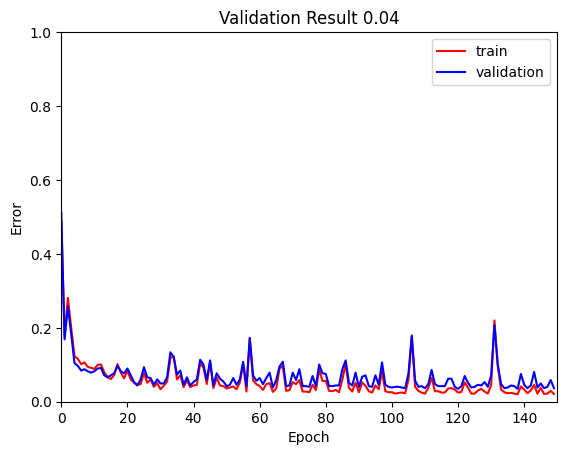

In [43]:
eval_GNN(BaselineGNN(768, 128, 2), gc_train, gc_val, gc_test, batch_size=128, epochs=150)

Epoch: 00, Loss: 0.7844, Train: 0.5806, Val: 0.4194, Test: 0.4887
Epoch: 01, Loss: 0.7387, Train: 0.5806, Val: 0.4194, Test: 0.4887
Epoch: 02, Loss: 0.7162, Train: 0.5806, Val: 0.4194, Test: 0.4887
Epoch: 03, Loss: 0.7045, Train: 0.5806, Val: 0.4194, Test: 0.4887
Epoch: 04, Loss: 0.6597, Train: 0.5806, Val: 0.4194, Test: 0.4887
Epoch: 05, Loss: 0.6843, Train: 0.5806, Val: 0.4194, Test: 0.4887
Epoch: 06, Loss: 0.7071, Train: 0.5806, Val: 0.4194, Test: 0.4887
Epoch: 07, Loss: 0.6895, Train: 0.5806, Val: 0.4194, Test: 0.4887
Epoch: 08, Loss: 0.6700, Train: 0.5806, Val: 0.4194, Test: 0.4887
Epoch: 09, Loss: 0.6668, Train: 0.5806, Val: 0.4194, Test: 0.4887
Epoch: 10, Loss: 0.6512, Train: 0.5806, Val: 0.4194, Test: 0.4887
Epoch: 11, Loss: 0.6946, Train: 0.5806, Val: 0.4194, Test: 0.4887
Epoch: 12, Loss: 0.6591, Train: 0.5806, Val: 0.4194, Test: 0.4887
Epoch: 13, Loss: 0.6805, Train: 0.5806, Val: 0.4194, Test: 0.4887
Epoch: 14, Loss: 0.6690, Train: 0.5806, Val: 0.4194, Test: 0.4887
Epoch: 15,

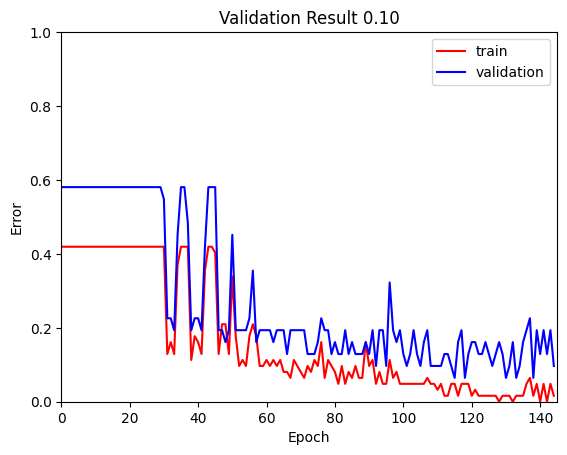

In [44]:
eval_GNN(BaselineGNN(768, 128, 2), pf_train, pf_val, pf_test, batch_size=128, epochs=145)